In [1]:
import os
import shutil
os.environ['OMPI_MCA_rmaps_base_oversubscribe'] = '1'
n_threads = 96
os.environ['USE_PYGEOS'] = '0'
os.environ['PROJ_LIB'] = '/opt/conda/share/proj/'
os.environ['NUMEXPR_MAX_THREADS'] = f'{n_threads}'
os.environ['NUMEXPR_NUM_THREADS'] = f'{n_threads}'
os.environ['OMP_THREAD_LIMIT'] = f'{n_threads}'
os.environ["OMP_NUM_THREADS"] = f'{n_threads}'
os.environ["OPENBLAS_NUM_THREADS"] = f'{n_threads}' # export OPENBLAS_NUM_THREADS=4 
os.environ["MKL_NUM_THREADS"] = f'{n_threads}' # export MKL_NUM_THREADS=6
os.environ["VECLIB_MAXIMUM_THREADS"] = f'{n_threads}' # export VECLIB_MAXIMUM_THREADS=4
import geopandas as gpd
import numpy as np
import pandas as pd
import skmap_bindings as sb
import tempfile
import cv2
import subprocess
import time
import sys
import matplotlib
import matplotlib.pyplot as plt
import random
from skmap.loader import warp_tile
from concurrent.futures import ProcessPoolExecutor, as_completed
import gc

gdal_opts = {
 'GDAL_HTTP_VERSION': '1.0',
 'CPL_VSIL_CURL_ALLOWED_EXTENSIONS': '.tif',
}

co = ['TILED=YES', 'BIGTIFF=YES', 'COMPRESS=DEFLATE', 'BLOCKXSIZE=1024', 'BLOCKYSIZE=1024']

executor = None

def ttprint(*args, **kwargs):
    from datetime import datetime
    import sys
    print(f'[{datetime.now():%H:%M:%S}] ', end='')
    print(*args, **kwargs, flush=True)

def make_tempdir(basedir='skmap', make_subdir = True):
    tempdir = Path(TMP_DIR).joinpath(basedir)
    if make_subdir: 
        name = Path(tempfile.NamedTemporaryFile().name).name
        tempdir = tempdir.joinpath(name)
    tempdir.mkdir(parents=True, exist_ok=True)
    return tempdir
    
def get_SWAG_weights(att_env, att_seas, season_size, n_imag):
    conv_mat_row = np.zeros((n_imag))
    base_func = np.zeros((season_size,))
    period_y = season_size/2.0
    slope_y = att_seas/10/period_y
    for i in np.arange(season_size):
        if i <= period_y:
            base_func[i] = -slope_y*i
        else:
            base_func[i] = slope_y*(i-period_y)-att_seas/10
    # Compute the envelop to attenuate temporarly far images
    env_func = np.zeros((n_imag,))
    delta_e = n_imag
    slope_e = att_env/10/delta_e
    for i in np.arange(delta_e):
        env_func[i] = -slope_e*i
        conv_mat_row = 10.0**(np.resize(base_func,n_imag) + env_func)
    return conv_mat_row    

def process_image_in_chunks(image, chunk_size, gap_stripes_th, gap_general_th, fft_th):
    mask = np.isnan(image)
    height, width = image.shape
    n_chunk_height = int(np.floor(height/chunk_size))
    n_chunk_width = int(np.floor(width/chunk_size))
    gap_fraq = np.zeros((n_chunk_height, n_chunk_width))
    fft_score = np.zeros((n_chunk_height, n_chunk_width))
    rec_flag = np.zeros((n_chunk_height, n_chunk_width))
    output_image = image.copy()
    row_starts, row_ends, col_starts, col_ends, fill_true_erase_false = [], [], [], [], []
    # Loop through the image by chunks
    for i in range(0, n_chunk_height):
        for j in range(0, n_chunk_width):
            # @FIXME check is also theretically the location of patial frequencies in different share chunks is the same 
            if i != (n_chunk_height-1):
                row_start, row_end = (i * chunk_size, (i+1) * chunk_size)
            else:
                row_start, row_end = (i * chunk_size, height)
            if j != (n_chunk_width-1):
                col_start, col_end = (j * chunk_size, (j+1) * chunk_size)
            else:
                col_start, col_end = (j * chunk_size, width)
            image_chunk = image[row_start:row_end, col_start:col_end]
            mask_chunk = mask[row_start:row_end, col_start:col_end]
            gap_count_chunk = np.sum(mask_chunk)
            gap_fraq[i, j] = gap_count_chunk/(row_end-row_start)/(col_end-col_start)
            if gap_fraq[i, j] < gap_general_th:
                row_starts += [row_start]
                row_ends += [row_end]
                col_starts += [col_start]
                col_ends += [col_end]
                fill_true_erase_false += [True]
                rec_flag[i,j] = 1
            else:
                image_filled = np.nan_to_num(image_chunk, nan=0)
                image_filled = image_filled[0:chunk_size,0:chunk_size].copy()
                # image_filled /= max(np.max(image_filled),1)
                image_filled[image_filled!=0] = 1
                ft = np.fft.ifftshift(image_filled)
                ft = np.fft.fft2(ft, norm='ortho')
                ft = np.fft.fftshift(ft)
                ft[48:80,48:80] = 0
                fft_score[i, j] = np.max(np.abs(ft))
                if fft_score[i, j] > fft_th:
                    row_starts += [row_start]
                    row_ends += [row_end]
                    col_starts += [col_start]
                    col_ends += [col_end]
                    if gap_fraq[i, j] < gap_stripes_th:
                        fill_true_erase_false += [True]
                        rec_flag[i,j] = 1
                    else:
                        fill_true_erase_false += [False]
                        rec_flag[i,j] = -1
                    
    return row_starts, row_ends, col_starts, col_ends, fill_true_erase_false, gap_fraq, fft_score, rec_flag

years = range(2000,2023)
x_size, y_size = (4004, 4004)
x_off, y_off = (0,0)
n_pix = x_size * y_size
no_data = 0
file_ending = '_go_epsg.4326_v20240521.tif'
n_imag_per_year = 23
n_imag_per_year_agg = 12
out_index_offset = 0
n_years = len(years)
n_s = n_years*n_imag_per_year
n_s_agg = n_years*n_imag_per_year_agg

bands_prefix = ['red_glad',
                'nir_glad',
                'qa_mask']
n_spect_bands = len(bands_prefix) - 1

doy_start = ['0101', '0117', '0202', '0218', '0305', '0321', '0406', '0422', '0508', '0524', '0609',
             '0625', '0711', '0727', '0812', '0828', '0913', '0929', '1015', '1031', '1116', '1202', '1218']

doy_end = ['0116', '0201', '0217', '0304', '0320', '0405', '0421', '0507', '0523', '0608', '0624',
           '0710', '0726', '0811', '0827', '0912', '0928', '1014', '1030', '1115', '1201', '1217', '1231']


month_start = ['0101', '0201', '0301', '0401', '0501', '0601', '0701', '0801', '0901', '1001', '1101', '1201']
month_end = ['0131', '0228', '0331', '0430', '0531', '0630', '0731', '0831', '0930', '1031', '1130', '1231']


# SWA time-series reconstruction parameters
att_env, att_seas, future_scaling = (20.0, 40.0, 0.1)

# MODIS NDVI filtering parameters
diff_th = 35
count_th = int(n_s/4)


resampling_strategy = "GRA_Bilinear"

# tiles = ['009E_04N', '009E_51N', '013E_61N', '050W_07S', '085W_52N', '091W_37N', '115E_03S', '127E_42N']
# tiles =                  ['009E_51N', '013E_61N', '127E_42N', 052W_19S] # ready tiles
# respective_MODIS_tile = ['?',         'h18v02',    '?',       'h13v10'] # ready tiles
# Command to copy MODIS data "seq 2000 2023 | xargs -I {} echo "mc find gaia/tmp-mod13q1.061-tif/{}/h18v02" | bash | grep ndvi | xargs -I {} echo "mc cp {} ." | parallel -j30"
# Command to rename MODIS files "for file in MOD13Q1.*.tif; do mv "$file" "$(echo "$file" | sed 's/\.[0-9]\{13\}//')"; done"
# landsat_tile = '051W_18S'
# modis_tile = 'h13v10'

landsat_tile = '013E_61N'
modis_tile = 'h18v02'

ttprint(f"Processing tile {landsat_tile}")
start = time.time()
landsat_files = []
for b in bands_prefix:
    for year in years:
        for m in range(n_imag_per_year):
            landsat_files.append(f'http://192.168.49.{random.randint(30,44)}:8333/prod-landsat-ard2/{landsat_tile}/raw/{b}.ard2_m_30m_s_{year}{doy_start[m]}_{year}{doy_end[m]}{file_ending}')
landsat_data = np.empty((n_s*4, n_pix), dtype=np.float32)
sb.readData(landsat_data, n_threads, landsat_files, range(len(landsat_files)), x_off, y_off, x_size, y_size, [1], gdal_opts, no_data, np.nan)
ttprint(f"Tile {landsat_tile} - Reading Landsat data: {(time.time() - start):.2f} s")


[14:09:40] Processing tile 013E_61N
[14:09:49] Tile 013E_61N - Reading Landsat data: 9.81 s


In [2]:
tile_files = []
for year in years:
    command = f'mc find gaia/tmp-mod13q1.061-tif/{year}/{modis_tile}/'
    tile_files += subprocess.check_output(command, shell=True, text=True).split('\n')
modis_files = []
ndvi_files = [s for s in tile_files if '_ndvi.tif' in s]
for year in years:
    for m in range(23):
        if (year == 2000) & (m < 3):
            m = 3
        if (year == 2016) & (m == 22):
            m = 21
        if (year == 2021) & (m == 17):
            m = 16
        time_frame_files = [s.replace('gaia/', f'http://192.168.49.{random.randint(30,44)}:8333/', 1) \
                            for s in ndvi_files if f'MOD13Q1.A{year}{str(1+16*m).zfill(3)}.{modis_tile}.061' in s]
        assert len(time_frame_files) == 1, f"Exactly one file should be selected year {year} month {m}"
        modis_files += time_frame_files
modis_data = np.empty((n_s, n_pix), dtype=np.float32)
start = time.time()
tile_template_paths = [landsat_files[i] for i in range(len(modis_files))]
executor = ProcessPoolExecutor(max_workers=n_threads)
futures = {executor.submit(warp_tile, i, tile_template_paths[i], modis_files[i], n_threads, 
                            n_pix, resampling_strategy, gdal_opts): i for i in range(len(modis_files))}
for future in as_completed(futures):
    i = futures[future]
    try:
        modis_data[i, :] = future.result()
    except Exception as e:
        print(f"Task {i} generated an exception: {e}")
executor.shutdown()
ttprint(f"Tile {landsat_tile} - Reading MODIS data: {(time.time() - start):.2f} s")

[14:11:37] Tile 013E_61N - Reading MODIS data: 98.43 s


In [3]:
start = time.time()

# NaN are -3000 but considering cubic spline interpolation we mass everything below -1000
sb.swapRowsValues(modis_data, n_threads, range(n_s), -500, np.nan, 'less')

w_p = (get_SWAG_weights(att_env, att_seas, n_imag_per_year, n_s)[1:][::-1]).astype(np.float32)
w_f = (get_SWAG_weights(att_env, att_seas, n_imag_per_year, n_s)[1:]).astype(np.float32)*future_scaling
w_0 = 1.0

modis_data_t = np.empty((n_pix, n_s), dtype=np.float32)
modis_rec_t = np.empty((n_pix, n_s), dtype=np.float32)
sb.transposeArray(modis_data, n_threads, modis_data_t)
sb.applyTsirf(modis_data_t, n_threads, modis_rec_t, n_s, 0, 0, w_0, w_p, w_f, True)

ttprint(f"Tile {landsat_tile} - Reconstructing MODIS with SWA: {(time.time() - start):.2f} s")

[14:12:16] Tile 013E_61N - Reconstructing MODIS with SWA: 39.02 s


In [4]:
start = time.time()

landsat_mask = np.empty((n_s, n_pix), dtype=np.float32)
sb.extractArrayRows(landsat_data, n_threads, landsat_mask, range(n_s*2, n_s*3))

# 14 = additional cloud buffer over land
# 3 = cloud
#                         0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17   
gap_mask_keep_buffer   = [1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0]
gap_mask_remove_buffer = [1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1]

# @FIXME this thing is basically not parallel
for i in range(n_s):
    n_cloud_pix = np.sum((landsat_mask[i] == 3)) + 1
    n_buff_pix = np.sum((landsat_mask[i] == 14)) + 1 # avoid division by 0
    gap_mask = gap_mask_remove_buffer if (n_cloud_pix/n_buff_pix) >= 1 else gap_mask_keep_buffer
    for k in range(0,18):
        sb.swapRowsValues(landsat_mask, n_threads, [i], k, gap_mask[k])


# N band dependent
for i in range(2):
    sb.maskData(landsat_data, n_threads, range(n_s*i, n_s*(i+1)), landsat_mask, 1., np.nan)
    
del landsat_mask
gc.collect()
ttprint(f"Tile {landsat_tile} - Masking Landsat data from QA: {(time.time() - start):.2f} s")


[14:15:23] Tile 013E_61N - Masking Landsat data from QA: 187.30 s


In [5]:
start = time.time()

band_scaling = 1/4e4
result_scaling = 1e4
result_offset = 0.
# N band dependent
sb.computeNormalizedDifference(landsat_data, n_threads,
                            range(n_s*1, n_s*2), range(n_s*0, n_s*1), range(n_s*3, n_s*4),
                            band_scaling, band_scaling, result_scaling, result_offset, [-1e4, 1e4])
landsat_NDVI_masked = np.empty((n_s, n_pix), dtype=np.float32)
sb.extractArrayRows(landsat_data, n_threads, landsat_NDVI_masked, range(n_s*3, n_s*4))
landsat_NDVI_masked_t = np.empty((n_pix, n_s), dtype=np.float32)
sb.transposeArray(landsat_NDVI_masked, n_threads, landsat_NDVI_masked_t)

# diff_th, count_th = (3000, int(0.3*n_s))
# diff_th, count_th = (1000, 12*n_years)
diff_th, count_th = (2500, 2*n_years)
modis_ndvi_mask_t = np.empty((n_pix, n_s), dtype=np.float32)
modis_ndvi_mask = np.empty((n_s, n_pix), dtype=np.float32)
sb.maskDifference(landsat_NDVI_masked_t, n_threads, diff_th, count_th, modis_rec_t, modis_ndvi_mask_t)
sb.transposeArray(modis_ndvi_mask_t, n_threads, modis_ndvi_mask)

# N band dependent
for i in range(n_spect_bands):
    sb.maskData(landsat_data, n_threads, range(n_s*i, n_s*(i+1)), modis_ndvi_mask, 1., np.nan)
del modis_rec_t
del modis_data
del modis_data_t
del landsat_NDVI_masked
del landsat_NDVI_masked_t
del modis_ndvi_mask
del modis_ndvi_mask_t
gc.collect()
ttprint(f"Tile {landsat_tile} - Masking Landsat data from MODIS NDVI: {(time.time() - start):.2f} s")

[14:15:40] Tile 013E_61N - Masking Landsat data from MODIS NDVI: 16.76 s


In [6]:
# start = time.time()
# landsat_data_copy = landsat_data.copy()
# ttprint(f"Tile {landsat_tile} - Coping Landsat data  {(time.time() - start):.2f} s")

[14:16:36] Tile 013E_61N - Coping Landsat data  55.98 s


In [7]:
start = time.time()
# N band dependent
# Impainting stripes parameters


fft_th = 1.5
gap_stripes_th, gap_general_th = 0.35, 0.05
chunk_size = 128
inpaint_radius = 3
inpaint_padding = 15
sample_idxs_band0, row_starts_band0, row_ends_band0, col_starts_band0, col_ends_band0, fill_true_erase_false_band0 = [], [], [], [], [], []
sample_idxs, row_starts, row_ends, col_starts, col_ends, fill_true_erase_false = [], [], [], [], [], []
for i in range(n_s):
    tmp_image = landsat_data[i].reshape(x_size, y_size)
    row_starts_tmp, row_ends_tmp, col_starts_tmp, col_ends_tmp, fill_true_erase_false_tmp, _, _, _ = process_image_in_chunks(tmp_image, chunk_size, gap_stripes_th, gap_general_th, fft_th)
    sample_idxs_band0 += [i for x in row_starts_tmp]
    row_starts_band0 += row_starts_tmp
    row_ends_band0 += row_ends_tmp
    col_starts_band0 += col_starts_tmp
    col_ends_band0 += col_ends_tmp
    fill_true_erase_false_band0 += fill_true_erase_false_tmp

for i in range(n_spect_bands):
    sample_idxs_band = [x + n_s*i for x in sample_idxs_band0]
    sample_idxs += sample_idxs_band
    row_starts += row_starts_band0
    row_ends += row_ends_band0
    col_starts += col_starts_band0
    col_ends += col_ends_band0
    fill_true_erase_false += fill_true_erase_false_band0
    
row_starts_fill, row_starts_erase = [], []
row_ends_fill, row_ends_erase = [], []
col_starts_fill, col_starts_erase = [], []
col_ends_fill, col_ends_erase = [], []
sample_idxs_fill, sample_idxs_erase = [], []
for si, rs, re, cs, ce, fe in zip(sample_idxs, row_starts, row_ends, col_starts, col_ends, fill_true_erase_false):
    if fe:
        row_starts_fill.append(rs)
        row_ends_fill.append(re)
        col_starts_fill.append(cs)
        col_ends_fill.append(ce)
        sample_idxs_fill.append(si)
    else:
        row_starts_erase.append(rs)
        row_ends_erase.append(re)
        col_starts_erase.append(cs)
        col_ends_erase.append(ce)
        sample_idxs_erase.append(si)
        
ttprint(f"Tile {landsat_tile} - Inpainting stripy areas P1: {(time.time() - start):.2f} s")
start = time.time()
sb.inpaintChunks(landsat_data, n_threads, inpaint_radius, inpaint_padding, x_size, y_size, sample_idxs_fill, row_starts_fill, row_ends_fill, col_starts_fill, col_ends_fill)
sb.eraseChunks(landsat_data, n_threads, x_size, y_size, sample_idxs_erase, row_starts_erase, row_ends_erase, col_starts_erase, col_ends_erase)
ttprint(f"Tile {landsat_tile} - Inpainting stripy areas P2: {(time.time() - start):.2f} s")

[14:20:09] Tile 013E_61N - Inpainting stripy areas P1: 213.30 s
[14:20:18] Tile 013E_61N - Inpainting stripy areas P2: 8.65 s


14


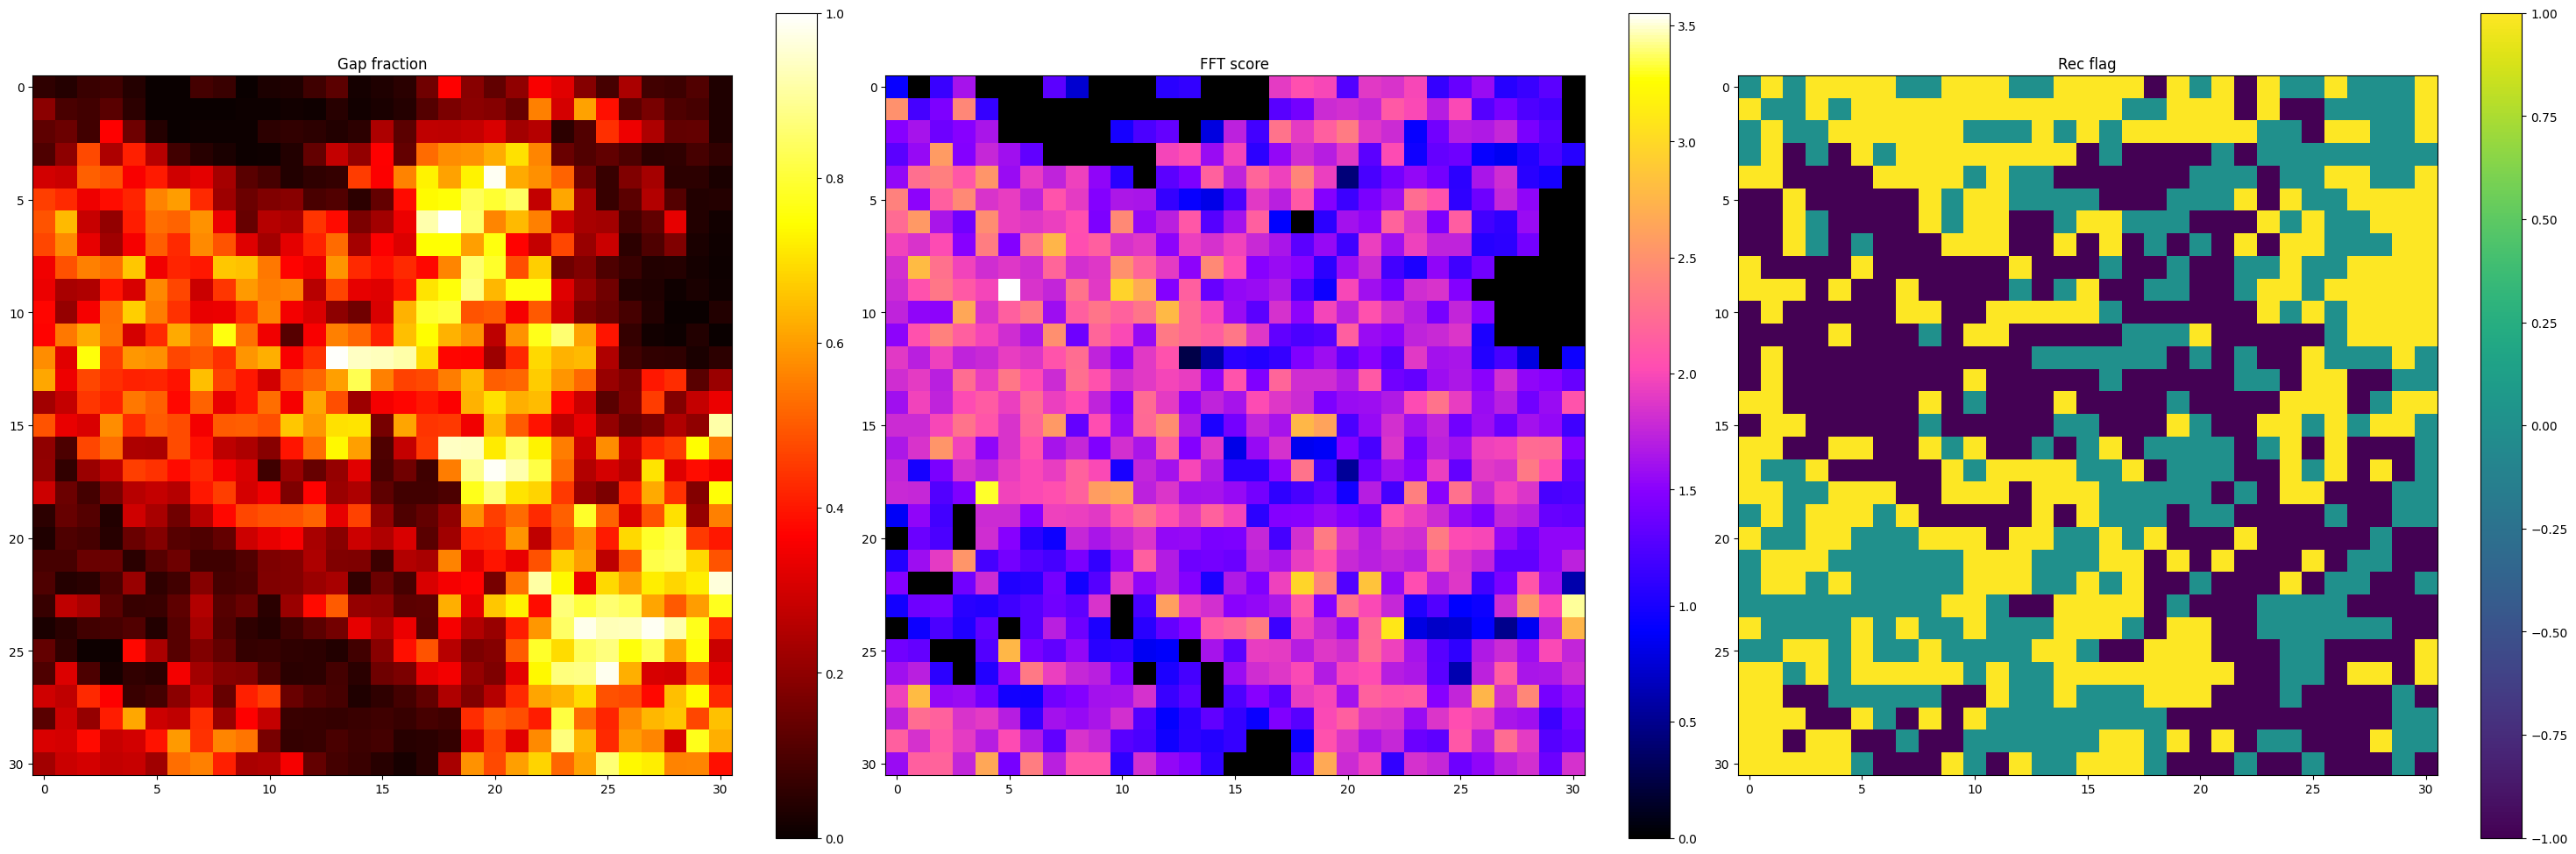

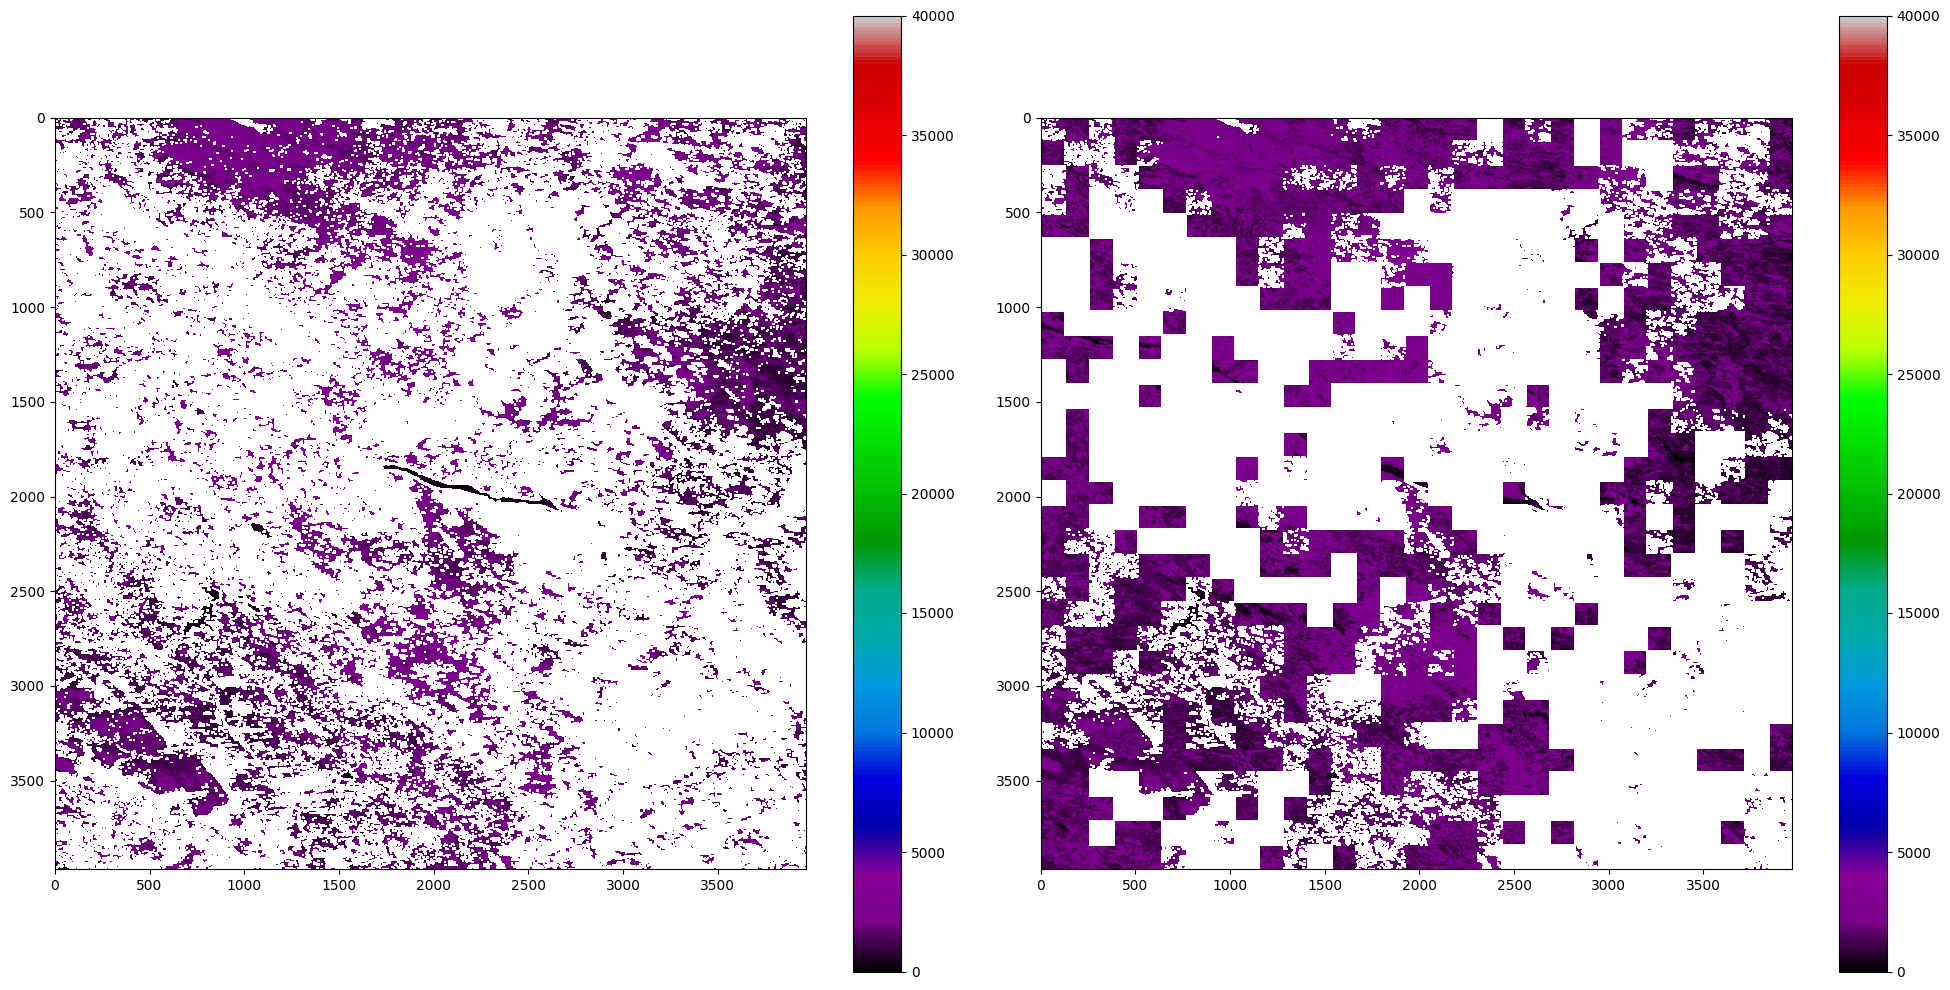

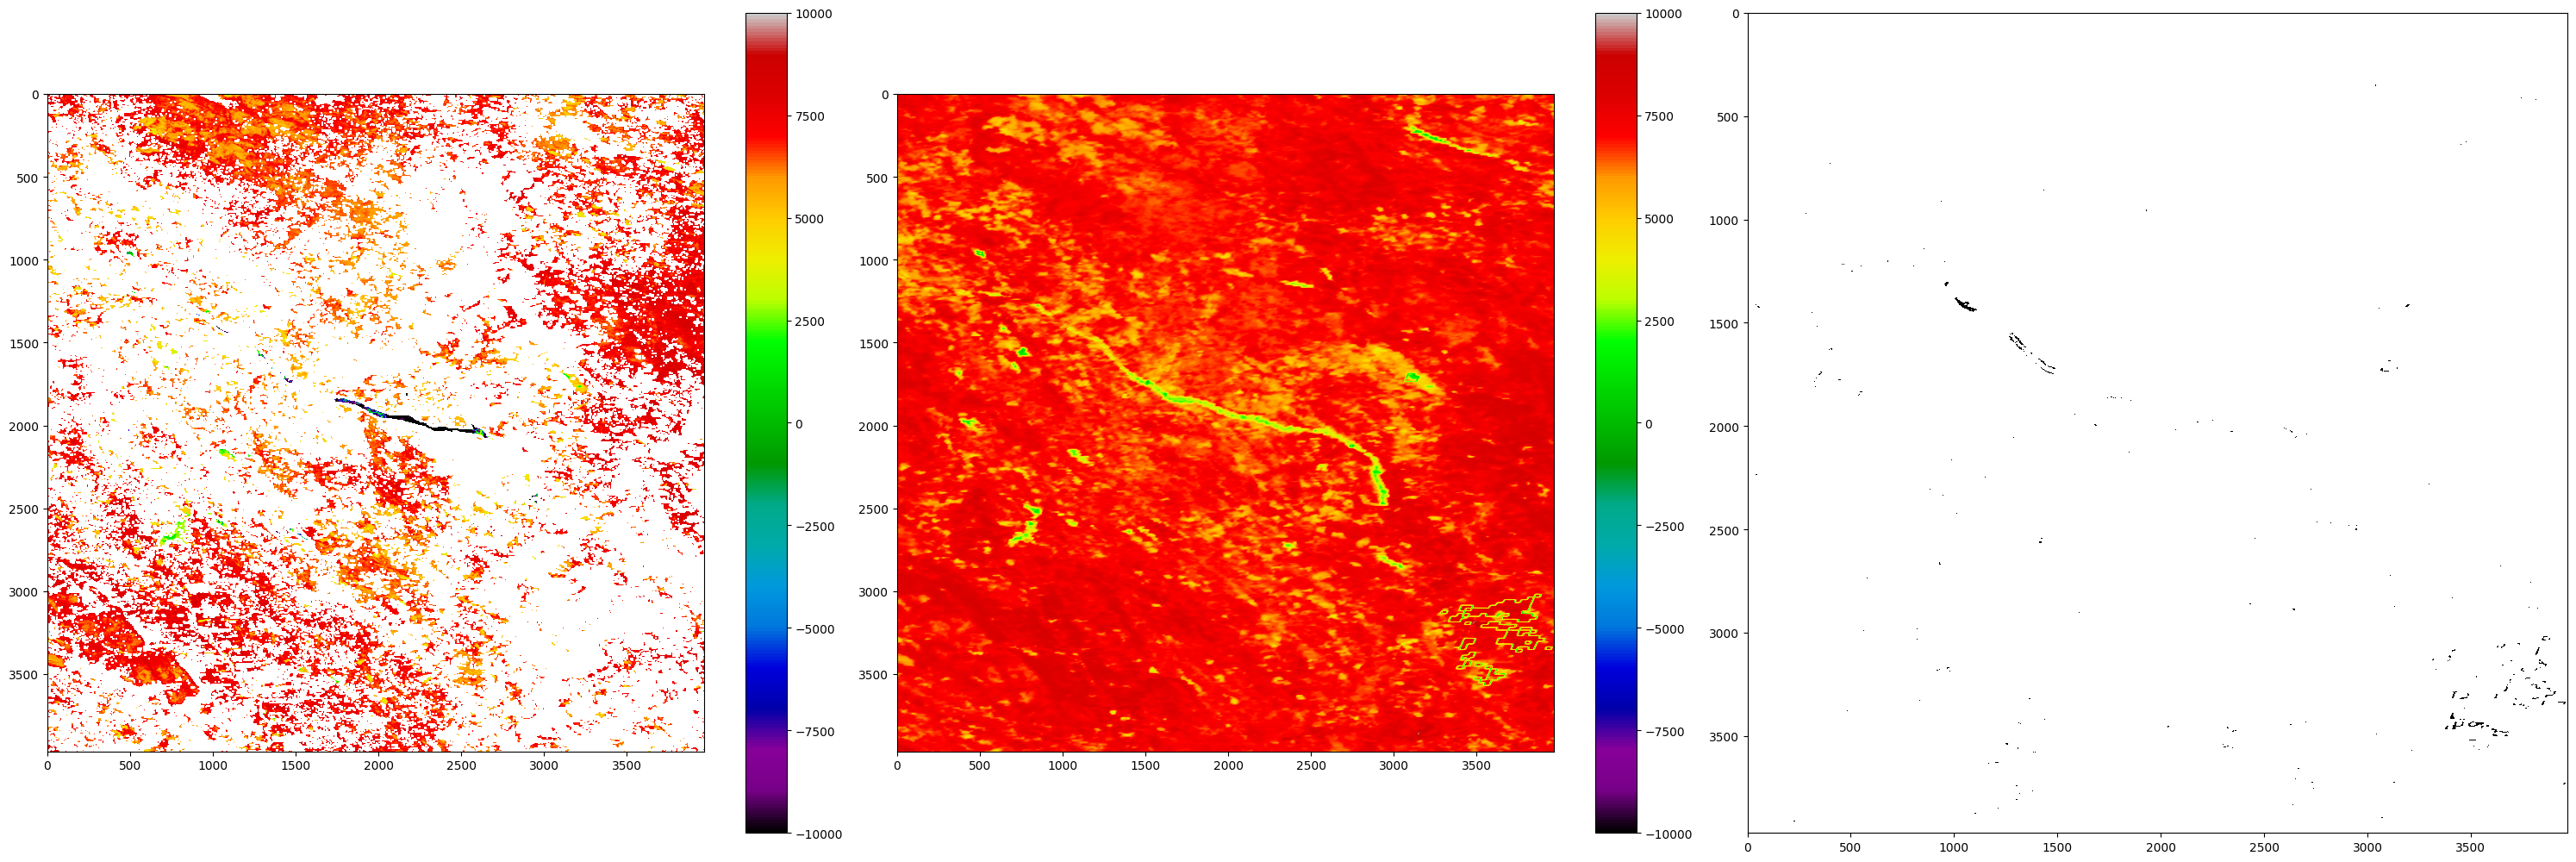

In [8]:
# # for i in range(23):
# for i in [14]:
#     print(i)
#     tmp_modis_ndvi_mask = modis_ndvi_mask[i].copy().reshape(x_size, y_size)
#     tmp_landsat_NDVI_masked = landsat_NDVI_masked[i].copy().reshape(x_size, y_size)
#     tmp_modis_rec = modis_rec_t[:,i].copy().reshape(x_size, y_size)
#     old_image = landsat_data_copy[i].copy().reshape(x_size, y_size)
#     inpainted_image = landsat_data[i].copy().reshape(x_size, y_size)
#     _, _, _, _, _, gap_fraq, fft_score, rec_flag = process_image_in_chunks(old_image, chunk_size, gap_stripes_th, gap_general_th, fft_th)
#     # plt_1, plt_2, plt_3, plt_4 = (28, 31, 28, 31)
#     # plt_1, plt_2, plt_3, plt_4 = (24, 31, 24, 31)
#     plt_1, plt_2, plt_3, plt_4 = (0, 31, 0, 31)
#     # plt_1, plt_2, plt_3, plt_4 = (0, 8, 0, 8)
#     plt.figure(figsize=(30,10))
#     plt.subplot(131)
#     plt.imshow(gap_fraq, cmap='hot', vmin=0)
#     plt.xlim([plt_1-0.5, plt_2-0.5])
#     plt.ylim([plt_4-0.5, plt_3-0.5])
#     plt.colorbar()
#     plt.title("Gap fraction")
#     plt.subplot(132)
#     plt.imshow(fft_score, cmap='gnuplot2', vmin=0)
#     plt.xlim([plt_1-0.5, plt_2-0.5])
#     plt.ylim([plt_4-0.5, plt_3-0.5])
#     plt.colorbar()
#     plt.tight_layout()
#     plt.title("FFT score")
#     plt.subplot(133)
#     plt.imshow(rec_flag, vmin=-1, vmax=1)
#     plt.xlim([plt_1-0.5, plt_2-0.5])
#     plt.ylim([plt_4-0.5, plt_3-0.5])
#     plt.tight_layout()
#     plt.colorbar()
#     plt.title("Rec flag")
#     plt.show()    
#     plt_1, plt_2, plt_3, plt_4 = (plt_1 * 128, plt_2 * 128, plt_3 * 128, plt_4 * 128)
#     plt.figure(figsize=(20,10))
#     plt.subplot(121)
#     plt.imshow(old_image, cmap='nipy_spectral', vmin=0, vmax=40000)
#     plt.colorbar()
#     plt.xlim([plt_1, plt_2])
#     plt.ylim([plt_4, plt_3])
#     plt.subplot(122)
#     plt.imshow(inpainted_image, cmap='nipy_spectral', vmin=0, vmax=40000)
#     plt.colorbar()
#     plt.xlim([plt_1, plt_2])
#     plt.ylim([plt_4, plt_3])
#     plt.tight_layout()
#     plt.show()
#     plt.figure(figsize=(30,10))
#     plt.subplot(131)
#     plt.imshow(tmp_landsat_NDVI_masked, cmap='nipy_spectral', vmin=-10000, vmax=10000)
#     plt.xlim([plt_1, plt_2])
#     plt.ylim([plt_4, plt_3])
#     plt.colorbar()
#     plt.subplot(132)
#     plt.imshow(tmp_modis_rec, cmap='nipy_spectral', vmin=-10000, vmax=10000)
#     plt.xlim([plt_1, plt_2])
#     plt.ylim([plt_4, plt_3])
#     plt.colorbar()
#     plt.tight_layout()
#     plt.subplot(133)
#     plt.imshow(tmp_modis_ndvi_mask, vmin=0, vmax=1, cmap=matplotlib.colors.ListedColormap(['white', 'black']))
#     plt.xlim([plt_1, plt_2])
#     plt.ylim([plt_4, plt_3])
#     plt.tight_layout()
#     plt.show()
    
    


In [14]:
del landsat_bands
gc.collect()

0

In [9]:
start = time.time()
landsat_bands = np.empty((n_s*n_spect_bands, n_pix), dtype=np.float32)
sb.extractArrayRows(landsat_data, n_threads, landsat_bands, range(0, n_s*n_spect_bands))
del landsat_data
gc.collect()
landsat_bands_t = np.empty((n_pix, n_s*n_spect_bands), dtype=np.float32)
sb.transposeArray(landsat_bands, n_threads, landsat_bands_t)
del landsat_bands
gc.collect()
landsat_bands_agg_t = np.empty((n_pix, n_s_agg*n_spect_bands), dtype=np.float32)
agg_pattern = []
for i in range(n_spect_bands):
    for j in range(n_years):
        base_idx = n_s*i + j*n_imag_per_year
        agg_pattern.append([base_idx+0,base_idx+1])
        agg_pattern.append([base_idx+2,base_idx+3])
        agg_pattern.append([base_idx+4,base_idx+5])
        agg_pattern.append([base_idx+6,base_idx+7])
        agg_pattern.append([base_idx+8,base_idx+9])
        agg_pattern.append([base_idx+10,base_idx+11])
        agg_pattern.append([base_idx+11,base_idx+12])
        agg_pattern.append([base_idx+13,base_idx+14])
        agg_pattern.append([base_idx+15,base_idx+16])
        agg_pattern.append([base_idx+17,base_idx+18])
        agg_pattern.append([base_idx+19,base_idx+20])
        agg_pattern.append([base_idx+21,base_idx+22])
        
sb.nanMeanAggregatePattern(landsat_bands_t, n_threads, landsat_bands_agg_t, agg_pattern)
del landsat_bands_t
gc.collect()

ttprint(f"Tile {landsat_tile} - Bands aggregation: {(time.time() - start):.2f} s")


[14:21:15] Tile 013E_61N - Bands aggregation: 47.72 s


In [22]:
start = time.time()

w_p_agg = (get_SWAG_weights(att_env, att_seas, n_imag_per_year_agg, n_s_agg)[1:][::-1]).astype(np.float32)
w_f_agg = (get_SWAG_weights(att_env, att_seas, n_imag_per_year_agg, n_s_agg)[1:]).astype(np.float32)*future_scaling
w_0_agg = 1.0
landsat_bands_rec_t = np.empty((n_pix, n_s_agg*n_spect_bands), dtype=np.float32)

# DEPENDS ON THE BAND
for b in range(n_spect_bands):
    sb.applyTsirf(landsat_bands_agg_t, n_threads, landsat_bands_rec_t, n_s_agg, b*n_s_agg, b*n_s_agg, w_0_agg, w_p_agg, w_f_agg, True)
del landsat_bands_agg_t
gc.collect()
ttprint(f"Tile {landsat_tile} - Reconstructing Landsat data with SWA: {(time.time() - start):.2f} s")

[14:34:54] Tile 013E_61N - Reconstructing Landsat data with SWA: 35.03 s


In [ ]:
# plt.plot(landsat_bands_agg_t[1,0:n_s_agg],'-o')
# plt.plot(landsat_bands_rec_t[1,0:n_s_agg],'-x')
# plt.show()
# plt.plot(landsat_bands_agg_t[1,n_s_agg:2*n_s_agg],'-o')
# plt.plot(landsat_bands_rec_t[1,n_s_agg:2*n_s_agg],'-x')
# plt.show()

In [23]:
start = time.time()

out_data = np.empty((n_s_agg*n_spect_bands, n_pix), dtype=np.float32)
sb.transposeArray(landsat_bands_rec_t, n_threads, out_data)
del landsat_bands_rec_t
gc.collect()

bands_prefix_out = ['red_glad',
                    'nir_glad']
file_ending_out = '_go_epsg.4326_v7'
out_dir = f'data_out/{landsat_tile}'
os.makedirs('data_out', exist_ok = True)
os.makedirs(out_dir, exist_ok = True)
no_data_out = 65000
compression_command = f"gdal_translate -a_nodata {no_data_out} -co COMPRESS=deflate -co ZLEVEL=9 -co TILED=TRUE -co BLOCKXSIZE=1024 -co BLOCKYSIZE=1024"
out_files = []
for band in bands_prefix_out:
    for year in years:
        for m in range(n_imag_per_year_agg):
            out_files.append(f'{band}.ard2_m_30m_s_{year}{month_start[m]}_{year}{month_end[m]}{file_ending_out}')

sb.writeUInt16Data(out_data, n_threads, gdal_opts, landsat_files[0:len(out_files)], out_dir, out_files, range(len(out_files)),
            x_off, y_off, x_size, y_size, no_data_out, compression_command)
ttprint(f"Tile {landsat_tile} - Saving data: {(time.time() - start):.2f} s")

del out_data
gc.collect()


[14:36:30] Tile 013E_61N - Saving data: 36.08 s
